In [52]:
# imports
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import itertools
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import math

In [53]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [54]:
input_size = 184
hidden_size = 30
num_classes = 4
testing_size = 0.2
validation_size = 0.2
num_epochs = 10
batch_size = 128
learning_rate = 0.001

In [55]:
transform = transforms.Compose([
     transforms.ToTensor(),
 ])

In [56]:
class CustomDataset(Dataset):

    def __init__(self, data_path, labels_path):
        # data loading
        x = pd.read_csv(data_path)
        y = pd.read_csv(labels_path)
        self.x = torch.tensor(x.to_numpy()) # tensor with the 184 values
        self.y = torch.tensor(y.to_numpy(), dtype=torch.long)  # tensor with the labels
        self.n_samples = x.shape[0]
    
    def __getitem__(self, index):
        return self.x[index], self.y[index]
    
    def __len__(self):
        return self.n_samples

# y paths are constant and non variable
y_train = "/home/ivan/Documentos/ivan/ready/train/y/y.csv"
y_val = "/home/ivan/Documentos/ivan/ready/val/y/y.csv"

# x
x_train = "/home/ivan/Documentos/ivan/ready/train/x/x.csv"
x_val = "/home/ivan/Documentos/ivan/ready/val/x/x.csv"

# dx
dx_train = "/home/ivan/Documentos/ivan/ready/train/dx/dx.csv"
dx_val = "/home/ivan/Documentos/ivan/ready/val/dx/dx.csv"

# dx
d2x_train = "/home/ivan/Documentos/ivan/ready/train/d2x/d2x.csv"
d2x_val = "/home/ivan/Documentos/ivan/ready/val/d2x/d2x.csv"

df = CustomDataset(x_train, y_train)
val_df = CustomDataset(x_val, y_val)

In [57]:
train_df, test_df = train_test_split(df, test_size = testing_size)

In [58]:
# Data loaders for training and validation sets
train_loader = torch.utils.data.DataLoader(dataset=train_df, batch_size=batch_size, shuffle=True) 
val_loader = torch.utils.data.DataLoader(dataset=val_df, batch_size=batch_size, shuffle=False)

# The test_loader remains unchanged for the test set
test_loader = torch.utils.data.DataLoader(dataset=test_df, batch_size=batch_size, shuffle=False)

In [59]:
class FCNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(FCNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size).double()
        self.drop = nn.Dropout(0.)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, num_classes).double()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

model = FCNet(input_size, hidden_size, num_classes).to(device)

In [60]:
# Hyper-parameters
learning_rate = 0.001
# optimizer
criterion = nn.CrossEntropyLoss()
#Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [61]:
def Train(model,train_loader,optimizer):
    correct = 0
    total = 0
    for i, (values, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        values = values.to(device)
        labels = labels.double().to(device)

        labels = labels.squeeze()
        
        # Forward pass
        outputs = model(values)
        loss = criterion(outputs, labels.long())
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    accuracy = (100 * correct / total)

    return loss.item(), accuracy

In [62]:
def Validate(model,val_loader):
  with torch.no_grad():
      correct = 0
      total = 0
      for values, labels in val_loader:
          values = values.to(device)
          labels = labels.double().to(device)

          labels = labels.squeeze()

          # Forward pass
          outputs = model(values)
          loss = criterion(outputs, labels.long())
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      accuracy = (100 * correct / total)
  return loss.item(),accuracy

In [63]:
# Hyper-parameters
num_epochs = 100
T_loss= []
v_loss =[]
T_acc = []
v_acc = []

# run
for epoch in range(num_epochs):

  train_loss, train_acc = Train(model, train_loader, optimizer)
  val_loss, val_acc = Validate(model, val_loader)

  print ('Epoch [{}/{}], train Loss: {:.4f}, train acc: {:.4f}, val Loss: {:.4f} , val acc: {:.4f}'
            .format(epoch+1, num_epochs, train_loss,train_acc, val_loss,val_acc))
  T_loss.append(train_loss)
  v_loss.append(val_loss)
  T_acc.append(train_acc)
  v_acc.append(val_acc)

Epoch [1/100], train Loss: 1.3843, train acc: 25.0914, val Loss: 1.2753 , val acc: 25.0954
Epoch [2/100], train Loss: 1.3718, train acc: 25.0914, val Loss: 1.2850 , val acc: 25.0954
Epoch [3/100], train Loss: 1.3637, train acc: 25.0914, val Loss: 1.2903 , val acc: 25.0954
Epoch [4/100], train Loss: 1.3380, train acc: 25.1162, val Loss: 1.2922 , val acc: 25.4482
Epoch [5/100], train Loss: 1.3320, train acc: 45.8390, val Loss: 1.2919 , val acc: 57.9688
Epoch [6/100], train Loss: 1.3249, train acc: 64.5443, val Loss: 1.2906 , val acc: 73.2772
Epoch [7/100], train Loss: 1.2709, train acc: 78.4449, val Loss: 1.2869 , val acc: 82.4571
Epoch [8/100], train Loss: 1.2158, train acc: 84.0700, val Loss: 1.2804 , val acc: 85.6453
Epoch [9/100], train Loss: 1.1906, train acc: 85.7964, val Loss: 1.2709 , val acc: 86.3255
Epoch [10/100], train Loss: 1.1657, train acc: 86.1689, val Loss: 1.2569 , val acc: 86.3160
Epoch [11/100], train Loss: 1.1060, train acc: 86.2355, val Loss: 1.2380 , val acc: 86.22

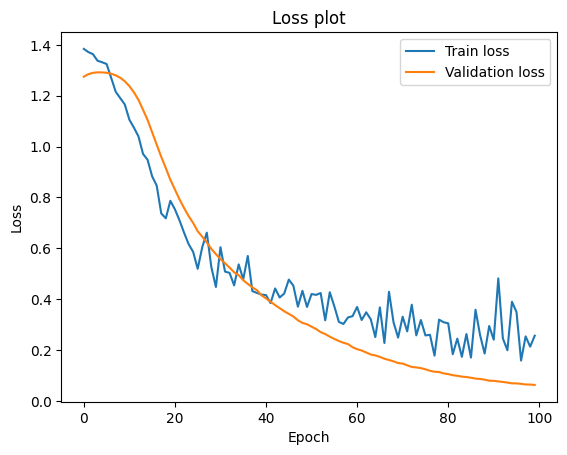

In [64]:
epochs = [i for i in range (num_epochs)]

plt.plot(epochs, T_loss, label='Train loss')
plt.plot(epochs, v_loss, label='Validation loss')

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

# Add a legend to distinguish lines
plt.legend()

# Display the plot
plt.show()


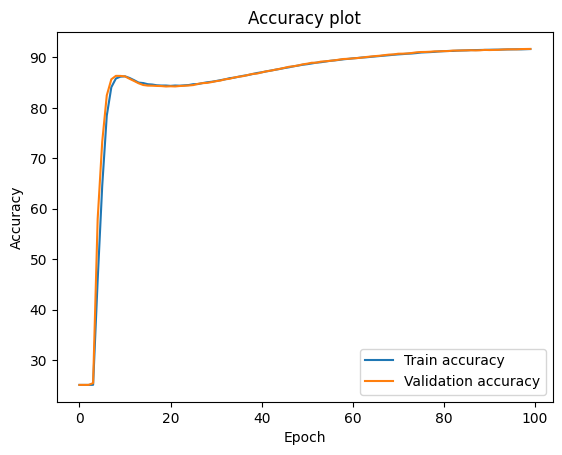

In [65]:
plt.plot(epochs, T_acc, label='Train accuracy')
plt.plot(epochs, v_acc, label='Validation accuracy')

# Add labels and a title
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

# Add a legend to distinguish lines
plt.legend()

# Display the plot
plt.show()

In [66]:
predict = []
with torch.no_grad():
    correct = 0
    total = 0
    for values, labels in test_loader:
        values = values.to(device)
        labels = labels.to(device)
        labels = labels.squeeze()
        outputs = model(values)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        predict.extend(predicted.tolist())



    print('Accuracy of the network: {} %'.format(100 * correct / total))
    print(len(predict))

Accuracy of the network: 91.41767323585505 %
25168


Confusion matrix, without normalization
[[6218    0    0    0]
 [   0 5408  834   20]
 [   0 1052 5302   13]
 [   0    3  238 6080]]


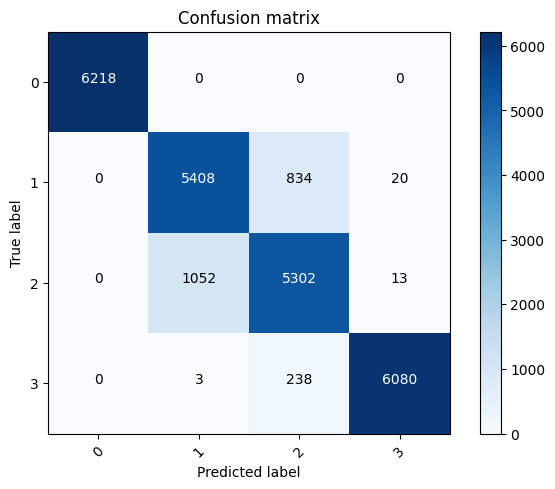

In [67]:
#confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  """
  This function prints and plots the confusion matrix.
  Normalization can be applied by setting `normalize=True`.
  """
  if normalize:
      cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
      print("Normalized confusion matrix")
  else:
      print('Confusion matrix, without normalization')

  print(cm)

  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title(title)
  plt.colorbar()
  tick_marks = np.arange(len(classes))
  plt.xticks(tick_marks, classes, rotation=45)
  plt.yticks(tick_marks, classes)

  fmt = '.2f' if normalize else 'd'
  thresh = cm.max() / 2.
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
      plt.text(j, i, format(cm[i, j], fmt),
               horizontalalignment="center",
               color="white" if cm[i, j] > thresh else "black")

  plt.tight_layout()
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.show()

x_test = []
y_test = []
for data, target in test_loader:
  x_test.extend(data)
  y_test.extend(target)

cm = confusion_matrix(y_test, predict)
plot_confusion_matrix(cm,list(range(4)))

In [68]:
#torch.save(model.state_dict(), 'test_model_ivan.ckpt')